<h1 align=center>Прогнозирование заказов такси</h1>

<h2>Задача:</h2>

Спрогнозировать количество заказов такси на следующий час на основе исторических данных компании

<h2>Требование:</h2>

Значение метрики RMSE на тестовой выборке должно быть <b>не больше 48</b>

## Содержание:
1. [Исследовательский анализ данных](#eda)
2. [Построение моделей](#model-selection)
    1. [Dummy](#model-dummy)
    2. [Catboost](#model-boost)
    3. [SARIMA](#model-sarima)
    4. [LTSM](#model-lstm)
    5. [NeuralProphet](#model-nprohet)
3. [Тестирование](#test)
4. [Заключение](#result)

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import copy

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
color = sns.color_palette("Set2")
RS = 42
#собираем rmse по моделям
total_dict = {}

from scipy.stats import poisson
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import catboost
import optuna
from neuralprophet import NeuralProphet

import torch
import torch.nn as nn
torch.manual_seed(42)

c:\users\cripe\appdata\local\programs\python\python39\lib\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


## Исследовательский анализ данных <a class="anchor" id="eda"></a>

In [3]:
data.head(5)

datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
#Переведем дату в тип datetime
data['datetime'] = pd.to_datetime(data['datetime'])

In [6]:
#проверка на монотонность временных меток, чтобы исключить вероятные разрывы(пропуски меток)
data['datetime'].is_monotonic

WARNING - (py.warnings._showwarnmsg) - C:\Users\cripe\AppData\Local\Temp\ipykernel_1040\1039957303.py:2: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  data['datetime'].is_monotonic



True

In [7]:
#переведем столбец в индекс
data.index = data['datetime']
data.drop('datetime', axis=1, inplace=True)
#отсортируем по возрастанию
data = data.sort_index()

In [8]:
#по условиию задачи требуется сделать ресемплинг по 1 часу
data = data.resample('1H').sum()

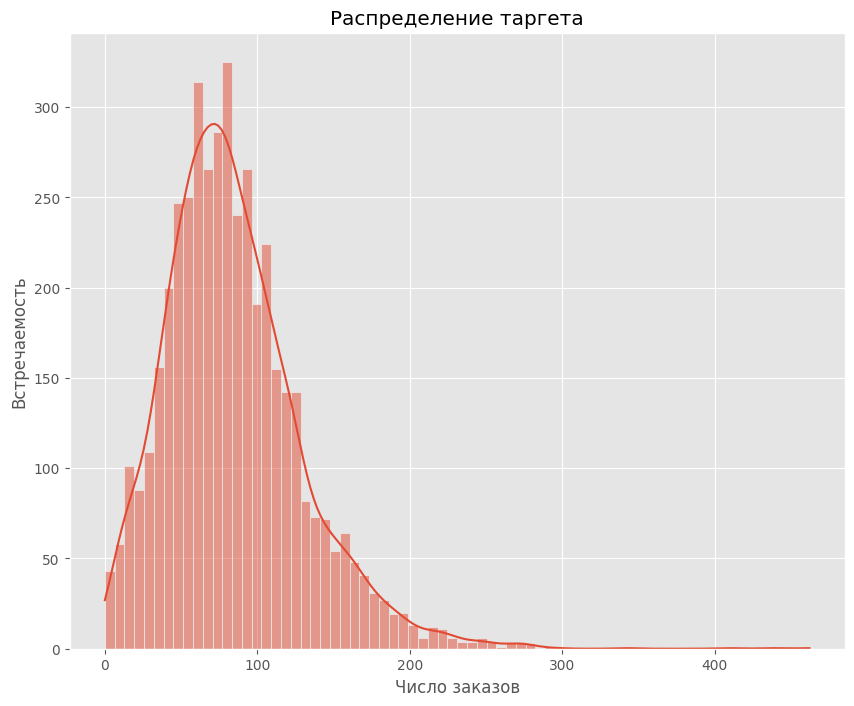

In [9]:
#распределение таргета
sns.histplot(data=(data['num_orders']), kde=True)
plt.title('Распределение таргета')
plt.xlabel('Число заказов')
plt.ylabel('Встречаемость')
plt.show()

In [10]:
#mu=n*p
mu = data['num_orders'].mean()
max_value = int(data['num_orders'].max())

In [11]:
poisson_dist = []
idx = []
for i in range(max_value+1):
    poisson_dist.append(poisson.pmf(k=i, mu=mu))
    idx.append(i)

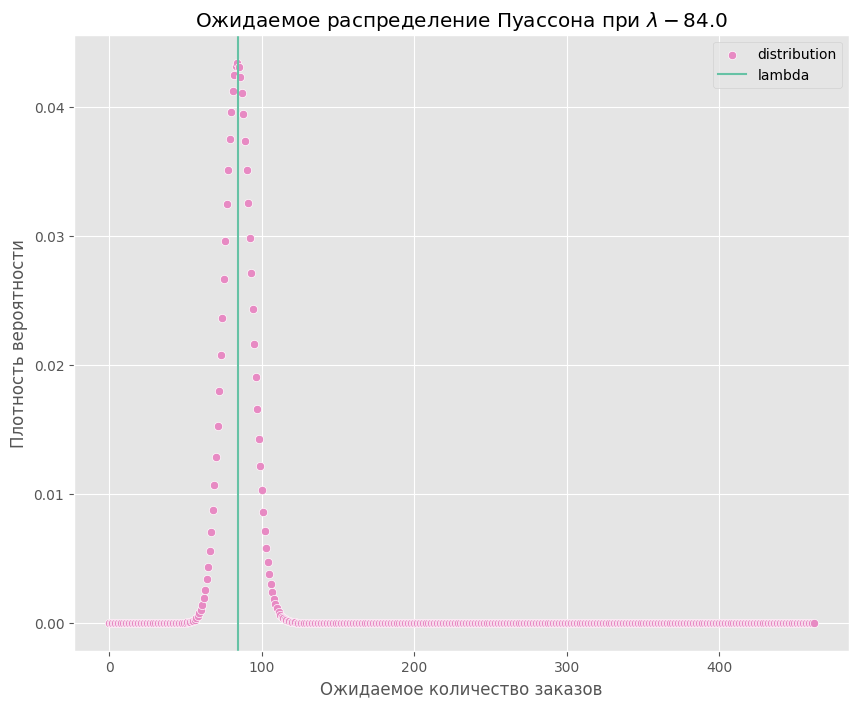

In [12]:
sns.scatterplot(y=np.array(poisson_dist), x=idx, color=color[3])
plt.title(f'Ожидаемое распределение Пуассона при $\lambda-{np.round(mu)}$')
plt.xlabel('Ожидаемое количество заказов')
plt.ylabel('Плотность вероятности')
plt.axvline(mu, color=color[0])
plt.legend(labels=['distribution', 'lambda'])
plt.show()

Формы распределения близки, но согласно распределению Пуассона с такой  λ шанс встретить число заказов больше 120 равны нулю.

Построим график, чтобы увидеть, как данные меняются со временем, оценим сезонность, тренд и шум

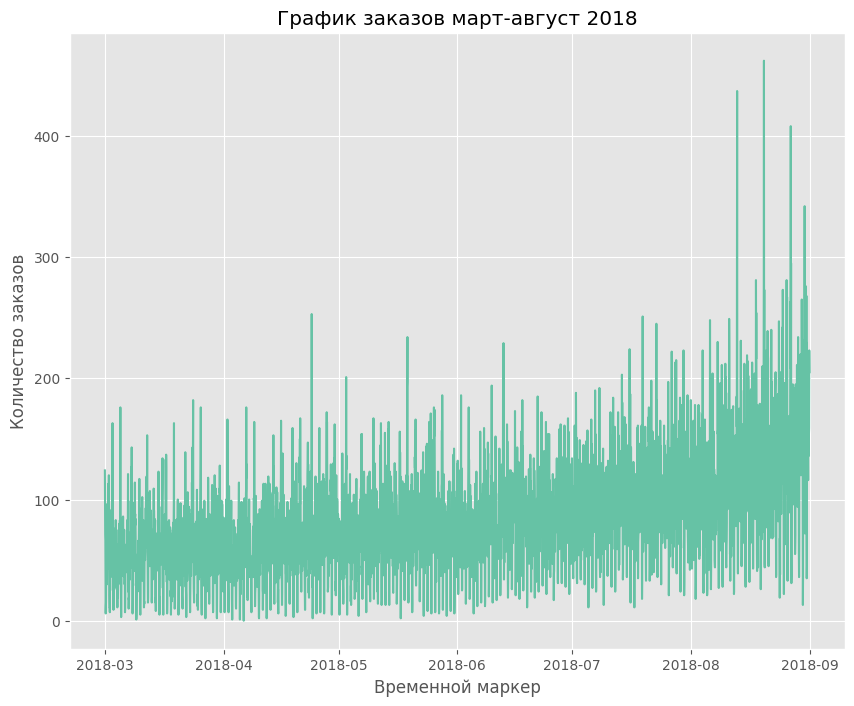

In [13]:
#график
sns.lineplot(data=data, x='datetime', y='num_orders', color=color[0])
plt.title('График заказов март-август 2018')
plt.xlabel('Временной маркер')
plt.ylabel('Количество заказов')
plt.show()

Даже сейчас, без какого-либо разложения, виден растущий тренд (радость компании и грусть для предсказания) и относительно ровное отклонение. Но следует подробнее ознакомиться с графиком

In [14]:
#разложим временной ряд методами библиотеки statsmodels
#данные берем за период 24 часа и 7 дней в неделю
hours, days, months = 24, 7, 6
decompose = seasonal_decompose(data['num_orders'], period=hours*days*months)

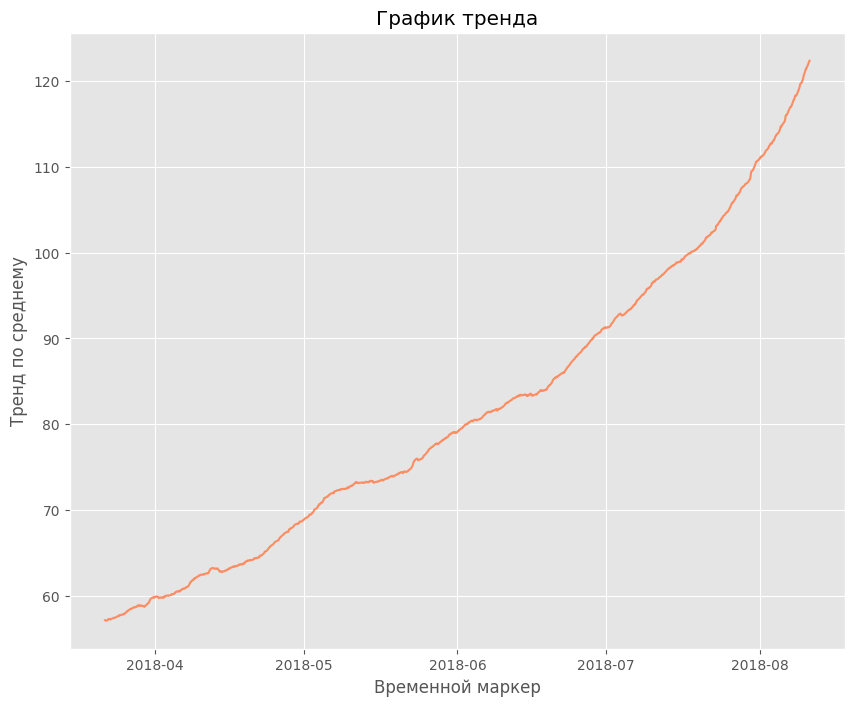

In [15]:
#график тренда
sns.lineplot(data=decompose.trend, color=color[1])
plt.title('График тренда')
plt.xlabel('Временной маркер')
plt.ylabel('Тренд по среднему')
plt.show()

Можно было бы еще сильнее сгладить линию тренда, установив периодичность свыше недели, но и так видно, что тренд возрастает, начиная со среднего чуть менее 60 доходя уже за 140

Стационарность ряда уже опровергнута (среднее растет), но можем убедиться этим окончательно, воспользовавшись метриками из эконометрики: расширенный тест Дики-Фуллера и тест KPSS(не путать с партией)

In [16]:
#тест Дики-Фуллера(расш.)
#регрессия константна, то есть подразумевает отсутствие тренда
dfuller_test = adfuller(data['num_orders'], autolag='AIC')
print(f'p-value Дики-Фуллера: {dfuller_test[1]}')

p-value Дики-Фуллера: 0.028940051402613506


Нулевая гипотеза теста гласит, что ряд не стационарен, альтернативная же говорит о стационарности ряда. P-value менее 5%, значит нулевая гипотеза отвергается. Наш ряд стационарен. Хотя мы видим, что среднее растет. Но подобный тест нередко врет и всегда стоит проверить тест 4 ученых, названных тестом KPSS

In [17]:
#тест KPSS
#регрессия константна, то есть подразумевает отсутствие тренда
kpss_test = kpss(data['num_orders'])
print(f'p-value KPSS: {kpss_test[1]}')

WARNING - (py.warnings._showwarnmsg) - c:\users\cripe\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(



p-value KPSS: 0.01


Нулевая гипотеза для теста KPSS гласит, что ряд стационарен, альтернативная - ряд не стационарен. Здесь мы видим более адекватный результат - нулевая гипотеза отвергнута, ряд - не стационарен. Это же подтверждается графиками. Теперь мы уверены на 99.9%, что ряд не стационарен (по правилу Кромвеля)

Проверим этот же ряд, но смещением на 1 шаг (также можно воспользоваться квадратным корнем или логарифмированием для выравнивая тренда в прямую линию)

In [18]:
#смещение на 5 шаг
diff_adfull = adfuller(data['num_orders'].diff(1).dropna())
diff_kpss = kpss(data['num_orders'].diff(1).dropna())
print(f'p-value Дики-Фуллера: {diff_adfull[1].round(5)}')
print(f'p-value KPSS: {diff_kpss[1]}')

WARNING - (py.warnings._showwarnmsg) - c:\users\cripe\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(



p-value Дики-Фуллера: 0.0
p-value KPSS: 0.1


Дики-Фуллер продолжает не замечать линию тренда, KPSS же не изменился

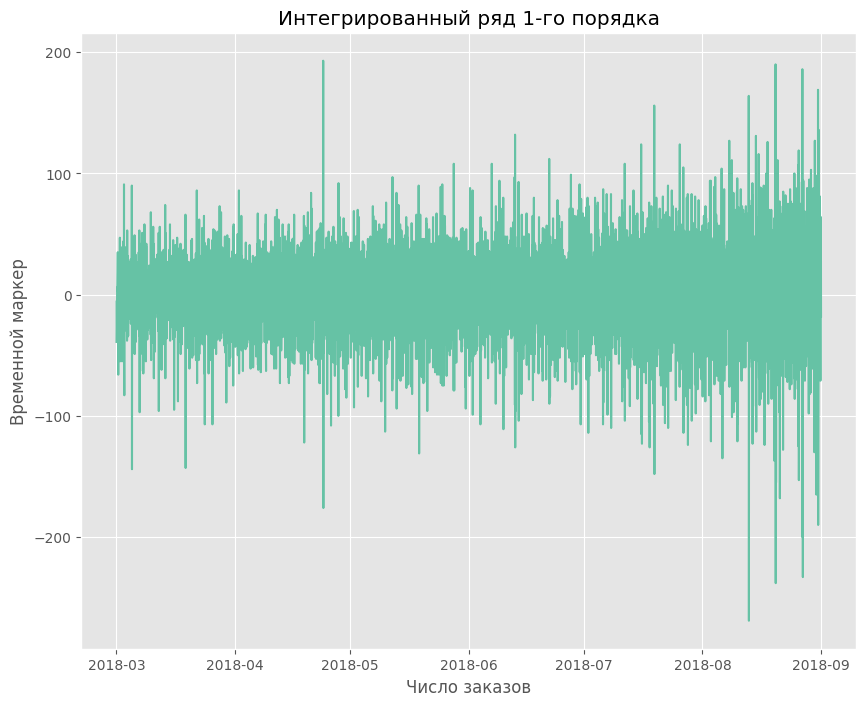

In [19]:
#строим график
sns.lineplot(data=data['num_orders'].diff(1), color=color[0])
plt.title('Интегрированный ряд 1-го порядка')
plt.xlabel('Число заказов')
plt.ylabel('Временной маркер')
plt.show()

Что мы видим по сезонности?

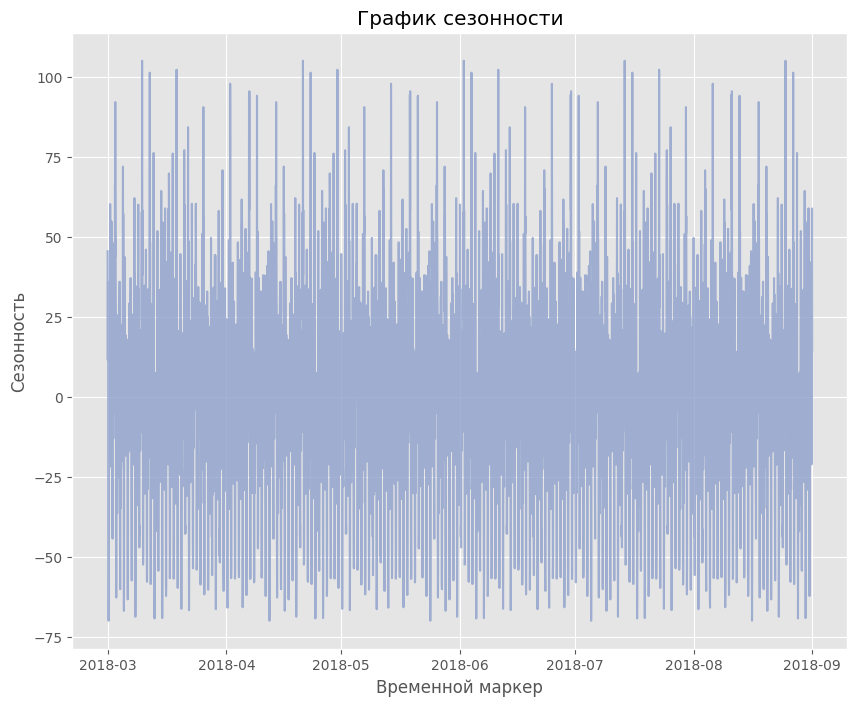

In [20]:
#график сезооности
sns.lineplot(data=decompose.seasonal, color=color[2], alpha=0.8)
plt.title('График сезонности')
plt.xlabel('Временной маркер')
plt.ylabel('Сезонность')
plt.show()

Не очень информативно, мы не видим чего-то явного, например, изменения между летом и весной. Но мы хотим посмотреть, как меняются заказы по месяцу, неделе, даже по дню. Сделаем интерактивный график

In [21]:
#интерактивный график
fig = px.line(
    data_frame=data.reset_index(),
    x='datetime',
    y='num_orders',
    width = 900,
    height = 600,
    title='Интерактивный график'
    
             )
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label='Day', step='day', stepmode='todate'),
            dict(count=6, label='Month', step='month', stepmode='todate'),
            dict(step='all')
        ])))
fig.show()

WARNING - (py.warnings._showwarnmsg) - c:\users\cripe\appdata\local\programs\python\python39\lib\site-packages\plotly_resampler\aggregation\algorithms\lttb_py.py:34: RuntimeWarning:

overflow encountered in longlong_scalars




Просмотрев данные на этом графике, можно прийти к выводу, что в районе полуночи заказов на такси больше всего. Меньшее же число заказов приходится на утренние часы (в районе 6-7 часов)

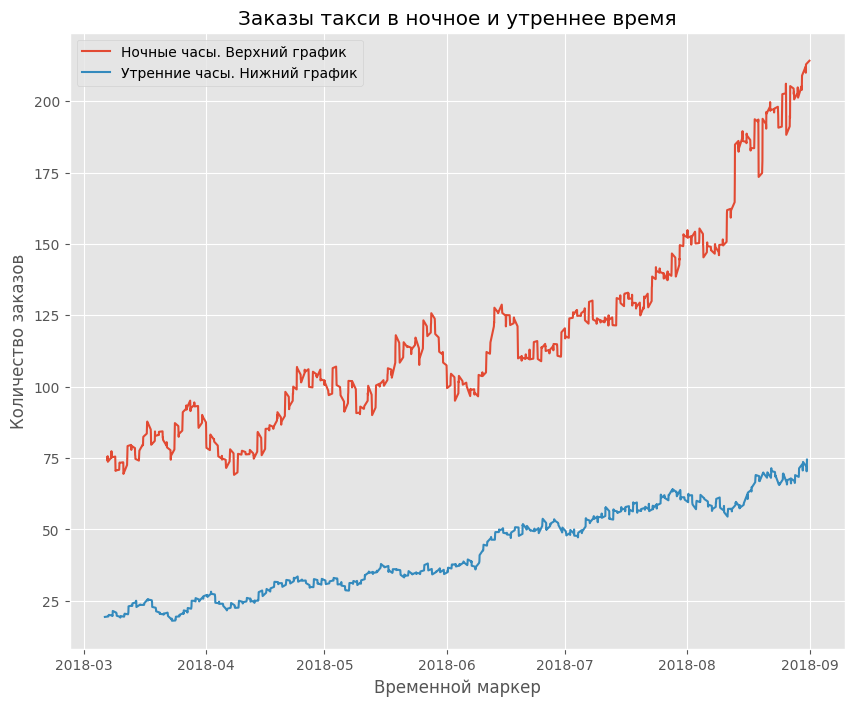

In [22]:
#отразим вышесказанное на графике
plt.plot(data.between_time('23:00', '02:00').rolling(24).mean())
plt.plot(data.between_time('05:00', '08:00').rolling(24).mean())
plt.legend(labels=['Ночные часы. Верхний график',
                  'Утренние часы. Нижний график'])
plt.title('Заказы такси в ночное и утреннее время')
plt.xlabel('Временной маркер')
plt.ylabel('Количество заказов')
plt.show()

Мы выяснили, что ночью заказов такси больше. Теперь стоит проверить автокорреляцию - насколько значения временного ряда коррелируют с его значениями в другие моменты времени. А если сказать иначе, есть ли сезонность?

In [23]:
#функция для построения acf
def get_acf(data, lag=35, title='Plot'):
    plot_acf(data, lags=lag, title=title) 

#функция для построения pacf
def get_pacf(data, lag=35, title='Plot'):
    plot_pacf(data, lags=lag, title=title)

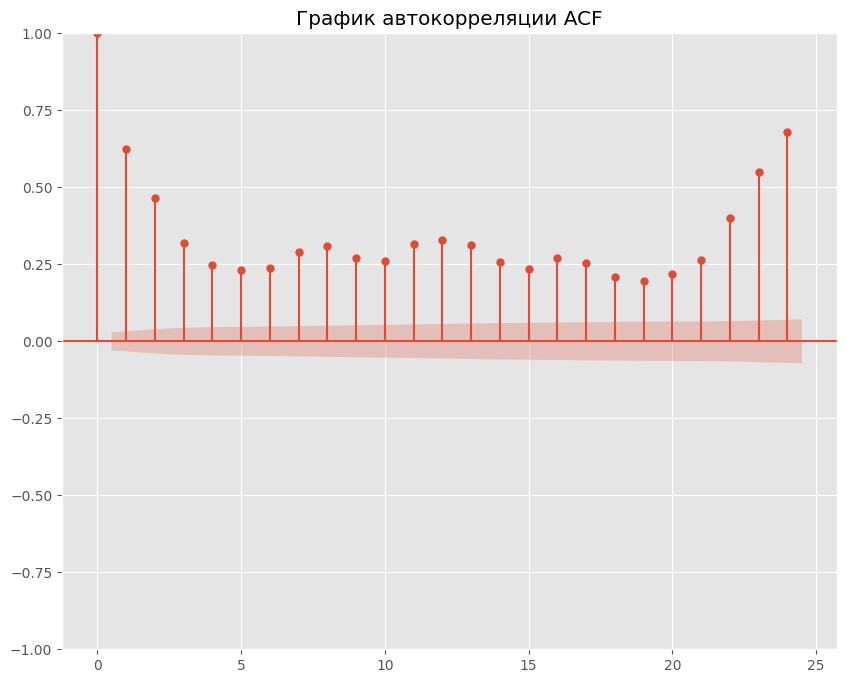

In [24]:
#строим график
get_acf(data['num_orders'], lag=24, title='График автокорреляции ACF')

Наибольшую автокорреляцию по лагам(смещениям) мы видим на отметках 1, 23, 24, 25.

WARNING - (py.warnings._showwarnmsg) - c:\users\cripe\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.




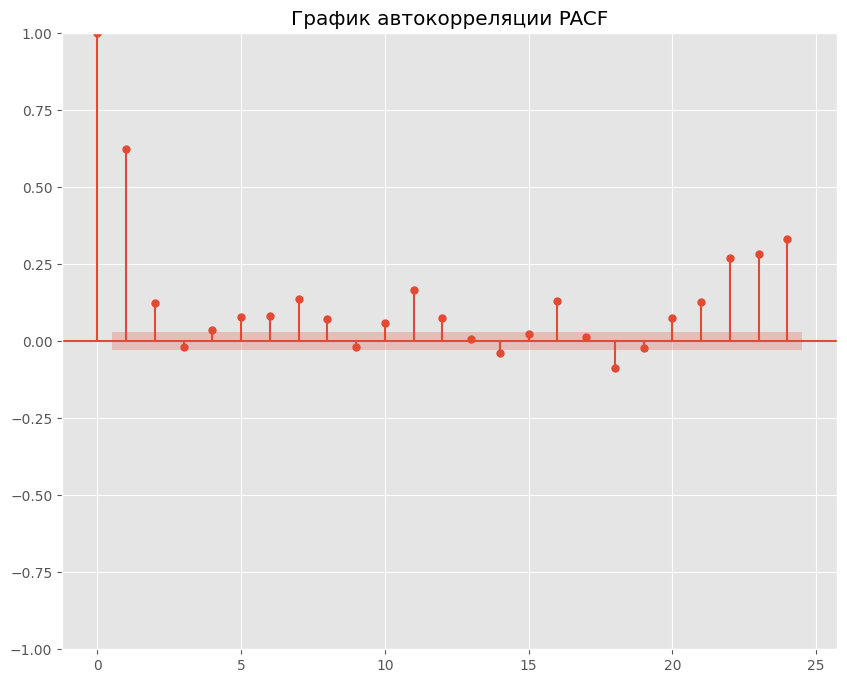

In [25]:
#строим pacf
get_pacf(data['num_orders'], lag=24, title='График автокорреляции PACF')

На частичной автокорреляции наибольшее значение наблюдается на отметке 1.
Так как большинство баров выходит за рамки доверительного интервала в 95%(бледная область), то наш временной ряд - не рандомный, а максимальная автокорреляция наблюдается при единице (0 не учитывается, т.к. несмещенный ряд максимально коррелирует с самим собой).

По причине выхода за рамки доверительного интервала мы может подвердить свое предположение о нестационарности, имеются выбросы

В следствие проделанной работы, мы можем установить следующие значения:
- $p$ - порядок компоненты авторегрессионной модели
- $d$ - порядок интегрированного ряда
- $q$ - порядок компоненты среднего скользящего среднего

1) В нашем случае $d$ равен 1, т.к. наш ряд 1-го порядка

2) $p$ равен 3, т.к. хотя бары превышают доверительный интервал в значительной мере (по графику ACF)

3) $q$ равен равен 1, т.к. только 1-й бар имеет значительный коэффициент частичной автокорреляции (график PACF).

Пока мы недалеко ушли, сразу определим $P$,$D$,$Q$,$s$. Эти параметры определяют сезонность
- $P$ - порядок сезонной авторегрессии
- $D$ - порядок сезонной разности (порядок интегрированного ряда
- $Q$ - сезонный параметр скользящего среднего
- $s$ - сезонный интервал (в нашем случае - возьмем за 24)

$D$ равен 1, найдем остальные значения

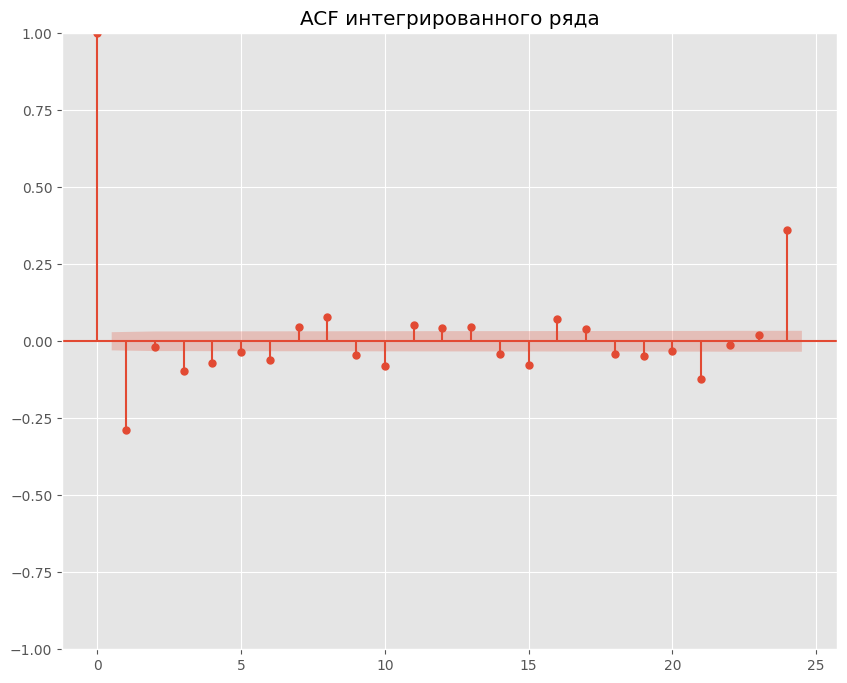

In [26]:
#график строим по среднему за день
get_acf(data['num_orders'].diff().dropna(), 24, 'ACF интегрированного ряда')

Можем наблюдать сезонность, каждые 24 часа бар поднимается

$P$ - предположим 2

WARNING - (py.warnings._showwarnmsg) - c:\users\cripe\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.




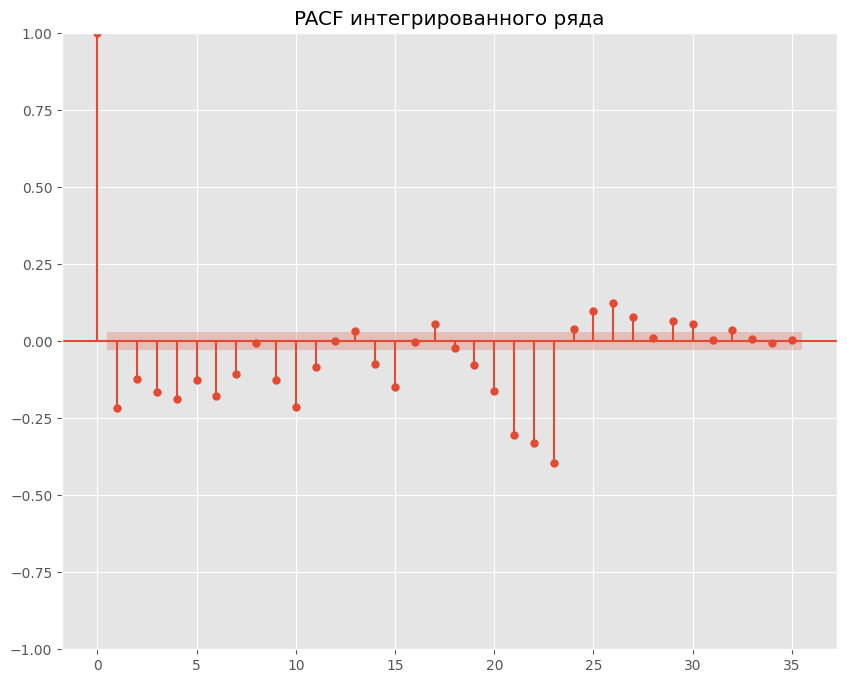

In [27]:
get_pacf(np.sqrt(data['num_orders']).diff(1).dropna(), 35, 'PACF интегрированного ряда')

$Q$  будет равно 3

$(p,d,q)*(P,D,Q){s} = (3,1,1)*(1,1,3)^{24}$

Таким образом, мы установили, что наши данные обладают и трендом, и сезонностью. Можно переходить к моделированию.
Выбросы мы оставим, прижимая их масштабированием и логарифмированием

## Построение моделей <a class="anchor" id="model-selection"></a>

### Dummy<a class="anchor" id="model-dummy"></a>

In [28]:
#начнем с дамми-модели
dum_split = int(data.shape[0] * 0.9)
y_dummy_prediction = [data[:dum_split].mean()] * data[dum_split:].shape[0]
dummy_rmse = np.sqrt(mean_squared_error(data[dum_split:], y_dummy_prediction))
f'RMSE dummy-модели: {dummy_rmse}'

'RMSE dummy-модели: 84.74414402014742'

Значение RMSE равно n*p, то есть среднеожидаемому значению в следующий час

### Catboost<a class="anchor" id="model-boost"></a>

У нас нет никаких признаков, кроме таргета и временного ряда, этого будет мало для регрессии. Поэтому займемся feature-engineering

In [29]:
def get_new_features(df, target_column, shifter=1, win_lag=None):
    
    """
    :::Функция генерирует новые признаки: год, месяц, день недели
    :::интервал смещения, скользящие средние, медиану и экспаненциальное среднее
    :::args: датафрейм, целевой столбец, смещение, размер скользщего окна
    :::return: датафрейм
    """
    df = df.copy()
    #генерируем по дате
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour/24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour/24.0)
    df['dow'] = df.index.dayofweek
    #выходные
    df['is_weekend'] = df['dow'].apply(lambda x: 1 if x in (6,7) else 0)
    
    #смещение
    if shifter:
        for i in range(1, shifter+1):
            df[f'diff_{i}'] = df[target_column].shift(periods=i)
    
    #скользящее окно
    if win_lag:
        df['sma'] = df[target_column].rolling(win_lag).mean()
        df['smm'] = df[target_column].rolling(win_lag).median()
        df['exp'] = df[target_column].expanding(win_lag).mean()
    
    #значения на следующий час, что мы и должны предсказать
    df['order_target'] = df['num_orders'].shift(-1)
    df.dropna(inplace=True)
    
    return df

In [30]:
#применяем
lin_reg_data = get_new_features(data, 'num_orders', shifter=4, win_lag=24)

In [31]:
#также напишем функцию, которая проставит праздничные дни весна-лето
#компания, вроде, российская
def holiday(df, weight=1):
    
    df = df.copy()
    
    def get_holiday():
        #проверяем на праздник, присваиваем вес
        date_idx = pd.Series(df.index)
        result = pd.Series(dtype='short')
        result['holiday'] = date_idx.apply(lambda x: weight if check_date(str(x)) else 0)
        
        return result['holiday'].values
    
    def check_date(string):
        #шаблон проверки с праздничными днями март-август
        pattern = r'05-09|05-01|03-08|06-12'
        result = re.findall(pattern, string)
        
        if result:
            return True
        return False
    
    return get_holiday()
    

In [32]:
#применяем функцию
lin_reg_data['holiday'] = holiday(lin_reg_data, 1)

In [33]:
lin_reg_data

num_orders  hour_sin      hour_cos  dow  is_weekend  \
datetime                                                                   
2018-03-01 23:00:00          58 -0.258819  9.659258e-01    3           0   
2018-03-02 00:00:00          90  0.000000  1.000000e+00    4           0   
2018-03-02 01:00:00         120  0.258819  9.659258e-01    4           0   
2018-03-02 02:00:00          75  0.500000  8.660254e-01    4           0   
2018-03-02 03:00:00          64  0.707107  7.071068e-01    4           0   
...                         ...       ...           ...  ...         ...   
2018-08-31 18:00:00         207 -1.000000 -1.836970e-16    4           0   
2018-08-31 19:00:00         136 -0.965926  2.588190e-01    4           0   
2018-08-31 20:00:00         154 -0.866025  5.000000e-01    4           0   
2018-08-31 21:00:00         159 -0.707107  7.071068e-01    4           0   
2018-08-31 22:00:00         223 -0.500000  8.660254e-01    4           0   

                     diff_1  diff_2  diff_3  diff_4         sma    smm  \
datetime                                                                 
2018-03-01 23:00:00   113.0    66.0    61.0    45.0   56.833333   59.5   
2018-03-02 00:00:00    58.0   113.0    66.0    61.0   55.416667   59.5   
2018-03-02 01:00:00    90.0    58.0   113.0    66.0   56.875000   59.5   
2018-03-02 02:00:00   120.0    90.0    58.0   113.0   57.041667   59.5   
2018-03-02 03:00:00    75.0   120.0    90.0    58.0   56.958333   59.5   
...                     ...     ...     ...     ...         ...    ...   
2018-08-31 18:00:00   217.0   197.0   116.0   133.0  164.875000  174.5   
2018-08-31 19:00:00   207.0   217.0   197.0   116.0  167.541667  174.5   
2018-08-31 20:00:00   136.0   207.0   217.0   197.0  168.041667  174.5   
2018-08-31 21:00:00   154.0   136.0   207.0   217.0  166.416667  166.5   
2018-08-31 22:00:00   159.0   154.0   136.0   207.0  169.125000  174.5   

                           exp  order_target  holiday  
datetime                                               
2018-03-01 23:00:00  56.833333          90.0        0  
2018-03-02 00:00:00  58.160000         120.0        0  
2018-03-02 01:00:00  60.538462          75.0        0  
2018-03-02 02:00:00  61.074074          64.0        0  
2018-03-02 03:00:00  61.178571          20.0        0  
...                        ...           ...      ...  
2018-08-31 18:00:00  84.319655         136.0        0  
2018-08-31 19:00:00  84.331369         154.0        0  
2018-08-31 20:00:00  84.347156         159.0        0  
2018-08-31 21:00:00  84.364069         223.0        0  
2018-08-31 22:00:00  84.395470         205.0        0  

[4392 rows x 14 columns]

Так как порядок имеет важное значение для временных рядов, то нам нужно сделать собственную функцию для кросс-валидации

In [34]:
def splitter(data, train_size=0.9):
    #функция делит выборку на две части
    data = data.copy()
    split = int(data.shape[0] * train_size)
    
    train, test = data.iloc[:split, :], data.iloc[split:, :]
    return train, test

In [35]:
#разбиваем
data_train, data_test = splitter(lin_reg_data, 0.9)
data_train, data_valid = splitter(data_train, 0.9)

In [36]:
#проверям разбиение
data_train.shape[0] + data_test.shape[0] + data_valid.shape[0] == lin_reg_data.shape[0]

True

In [37]:
#разбиваем на признаки и таргет
def get_x_y(data, target):
    X, y = data.drop(target, axis=1), data[target]
    return X, y

In [38]:
X_train_lr, y_train_lr = get_x_y(data_train, 'order_target')
X_valid_lr, y_valid_lr = get_x_y(data_valid, 'order_target')

In [39]:
#функция кросс-валидации
def get_cross_vall(model, X, y, n_splits, cat=False):

    #определяем размеры окна кросс-валидации в зависимости от количества сплитов
    batch_size = data.shape[0]//5
    train_size = int(batch_size * 0.8)
    valid_size = batch_size - train_size


    scores = []
    i = 0
    start = i * train_size
    end = train_size + start
    while i < 5:
        #трейн
        X_tr = X.iloc[0:end, :]
        y_tr = y.iloc[0:end]
        #обучаем модель
        model.fit(X_tr, y_tr)

        #валидация
        #если остается наблюдений больше валид-сайза
        if X.shape[0] - (end+valid_size) >= valid_size:
            X_val = data.iloc[end+valid_size, :]
            y_val = data.iloc[end+valid_size]
        #если остается наблюдений меньше валид-сайза
        else:
            X_val = data.iloc[end:, :]
            y_val = data[end:]  

        #предсказываем

        y_pred = model.predict(X_tr)
        rmse = np.sqrt(mean_squared_error(y_tr, y_pred))
        #добавляем в список скоров
        scores.append(rmse)

        start = end
        end = train_size + start
        i += 1
    model.fit(X, y)

    return np.mean(scores)


In [40]:
def linear_reg(X, y, n_splits, n_trials=10):
    """
    :::функция выполняет подбор гиперпараметров модели линейной регрессии
    :::на основе апостериорного распределения байесовской модели
    :::возвращает объект optuna с гиперпараметрами
    """

    
    def objective(trial):
        #определяем параметры
        params = {
            'iterations' : trial.suggest_int('iterations', 500, 2000, step=10),
            'learning_rate' : trial.suggest_float('learning_rate', 0.05, 0.3, step=0.05),
            'depth' : trial.suggest_int('depth', 3, 8, step=1),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.5, 5, step=0.5),
            'rsm': trial.suggest_float('rsm', 0.5, 1, step=0.1)
        }
        #инициализируем модель
        model = catboost.CatBoostRegressor(**params, random_seed=RS, verbose=100)
        #выполняем кросс-валидацию
        scores = get_cross_vall(model, X, y, n_splits=n_splits)
        
        return scores
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    return study

In [41]:
#предсказываем логарифм заказов, таким образом мы снизим излишнее влияние дисперсии
caboost_regression = linear_reg(X_train_lr, np.log1p(y_train_lr), n_splits=5)

[I 2023-03-23 15:51:32,389] A new study created in memory with name: no-name-fe3db2f2-7219-442b-a1c0-566b26ddb624


0:	learn: 0.5888926	total: 140ms	remaining: 3m 5s
100:	learn: 0.2279329	total: 196ms	remaining: 2.36s
200:	learn: 0.1669656	total: 245ms	remaining: 1.37s
300:	learn: 0.1259882	total: 294ms	remaining: 994ms
400:	learn: 0.0991946	total: 345ms	remaining: 790ms
500:	learn: 0.0794370	total: 394ms	remaining: 644ms
600:	learn: 0.0639655	total: 444ms	remaining: 531ms
700:	learn: 0.0519704	total: 493ms	remaining: 436ms
800:	learn: 0.0426852	total: 545ms	remaining: 353ms
900:	learn: 0.0347325	total: 596ms	remaining: 277ms
1000:	learn: 0.0281704	total: 645ms	remaining: 206ms
1100:	learn: 0.0236231	total: 694ms	remaining: 138ms
1200:	learn: 0.0198859	total: 743ms	remaining: 73.6ms
1300:	learn: 0.0162747	total: 796ms	remaining: 11.6ms
1319:	learn: 0.0157746	total: 806ms	remaining: 0us
0:	learn: 0.5960238	total: 654us	remaining: 863ms
100:	learn: 0.2709622	total: 61.4ms	remaining: 741ms
200:	learn: 0.2196905	total: 121ms	remaining: 671ms
300:	learn: 0.1827519	total: 186ms	remaining: 629ms
400:	learn

[I 2023-03-23 15:51:38,885] Trial 0 finished with value: 0.08002594568978849 and parameters: {'iterations': 1320, 'learning_rate': 0.2, 'depth': 4, 'l2_leaf_reg': 4.0, 'rsm': 0.9}. Best is trial 0 with value: 0.08002594568978849.


1200:	learn: 0.1384351	total: 1.03s	remaining: 102ms
1300:	learn: 0.1316228	total: 1.11s	remaining: 16.2ms
1319:	learn: 0.1307563	total: 1.13s	remaining: 0us
0:	learn: 0.6269728	total: 387us	remaining: 449ms
100:	learn: 0.3083075	total: 31.8ms	remaining: 334ms
200:	learn: 0.2665478	total: 63.8ms	remaining: 304ms
300:	learn: 0.2407480	total: 94.9ms	remaining: 271ms
400:	learn: 0.2180767	total: 125ms	remaining: 238ms
500:	learn: 0.2004179	total: 156ms	remaining: 205ms
600:	learn: 0.1855753	total: 186ms	remaining: 173ms
700:	learn: 0.1716280	total: 217ms	remaining: 142ms
800:	learn: 0.1593050	total: 247ms	remaining: 111ms
900:	learn: 0.1482665	total: 278ms	remaining: 79.8ms
1000:	learn: 0.1383649	total: 308ms	remaining: 48.9ms
1100:	learn: 0.1295494	total: 338ms	remaining: 18.1ms
1159:	learn: 0.1239142	total: 356ms	remaining: 0us
0:	learn: 0.6348898	total: 435us	remaining: 504ms
100:	learn: 0.3343715	total: 38ms	remaining: 399ms
200:	learn: 0.3054276	total: 76.6ms	remaining: 365ms
300:	le

[I 2023-03-23 15:51:42,741] Trial 1 finished with value: 0.1947377426067752 and parameters: {'iterations': 1160, 'learning_rate': 0.1, 'depth': 3, 'l2_leaf_reg': 4.0, 'rsm': 0.5}. Best is trial 0 with value: 0.08002594568978849.


1100:	learn: 0.2357083	total: 625ms	remaining: 33.5ms
1159:	learn: 0.2332416	total: 658ms	remaining: 0us
0:	learn: 0.6264459	total: 785us	remaining: 1.46s
100:	learn: 0.2619337	total: 73.8ms	remaining: 1.28s
200:	learn: 0.2150308	total: 147ms	remaining: 1.22s
300:	learn: 0.1730071	total: 220ms	remaining: 1.14s
400:	learn: 0.1413426	total: 292ms	remaining: 1.06s
500:	learn: 0.1169784	total: 365ms	remaining: 990ms
600:	learn: 0.0995179	total: 439ms	remaining: 919ms
700:	learn: 0.0861028	total: 515ms	remaining: 851ms
800:	learn: 0.0743355	total: 588ms	remaining: 777ms
900:	learn: 0.0623975	total: 661ms	remaining: 703ms
1000:	learn: 0.0536082	total: 733ms	remaining: 629ms
1100:	learn: 0.0451197	total: 806ms	remaining: 555ms
1200:	learn: 0.0387887	total: 878ms	remaining: 482ms
1300:	learn: 0.0338178	total: 951ms	remaining: 409ms
1400:	learn: 0.0295722	total: 1.02s	remaining: 336ms
1500:	learn: 0.0257268	total: 1.1s	remaining: 263ms
1600:	learn: 0.0225740	total: 1.17s	remaining: 190ms
1700:	

[I 2023-03-23 15:51:54,975] Trial 2 finished with value: 0.07539933398964854 and parameters: {'iterations': 1860, 'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 5.0, 'rsm': 0.9}. Best is trial 2 with value: 0.07539933398964854.


0:	learn: 0.5812452	total: 1.57ms	remaining: 3.08s
100:	learn: 0.1269708	total: 167ms	remaining: 3.07s
200:	learn: 0.0597421	total: 344ms	remaining: 3.01s
300:	learn: 0.0285401	total: 508ms	remaining: 2.8s
400:	learn: 0.0133762	total: 700ms	remaining: 2.72s
500:	learn: 0.0071440	total: 909ms	remaining: 2.65s
600:	learn: 0.0037131	total: 1.07s	remaining: 2.43s
700:	learn: 0.0019986	total: 1.29s	remaining: 2.32s
800:	learn: 0.0010925	total: 1.54s	remaining: 2.23s
900:	learn: 0.0006351	total: 1.76s	remaining: 2.07s
1000:	learn: 0.0003563	total: 1.94s	remaining: 1.86s
1100:	learn: 0.0001945	total: 2.11s	remaining: 1.65s
1200:	learn: 0.0001111	total: 2.28s	remaining: 1.44s
1300:	learn: 0.0000642	total: 2.45s	remaining: 1.24s
1400:	learn: 0.0000368	total: 2.61s	remaining: 1.04s
1500:	learn: 0.0000190	total: 2.78s	remaining: 850ms
1600:	learn: 0.0000107	total: 2.95s	remaining: 661ms
1700:	learn: 0.0000059	total: 3.11s	remaining: 474ms
1800:	learn: 0.0000034	total: 3.29s	remaining: 290ms
1900:

[I 2023-03-23 15:52:20,722] Trial 3 finished with value: 0.0025252261222894847 and parameters: {'iterations': 1960, 'learning_rate': 0.25, 'depth': 7, 'l2_leaf_reg': 4.5, 'rsm': 0.6}. Best is trial 3 with value: 0.0025252261222894847.


0:	learn: 0.5879687	total: 374us	remaining: 396ms
100:	learn: 0.2554280	total: 35.6ms	remaining: 338ms
200:	learn: 0.2019466	total: 67.8ms	remaining: 290ms
300:	learn: 0.1671991	total: 97.8ms	remaining: 246ms
400:	learn: 0.1413719	total: 128ms	remaining: 211ms
500:	learn: 0.1220556	total: 158ms	remaining: 177ms
600:	learn: 0.1051706	total: 190ms	remaining: 145ms
700:	learn: 0.0911095	total: 221ms	remaining: 113ms
800:	learn: 0.0798235	total: 251ms	remaining: 81.2ms
900:	learn: 0.0695944	total: 282ms	remaining: 49.7ms
1000:	learn: 0.0613998	total: 312ms	remaining: 18.4ms
1059:	learn: 0.0570053	total: 330ms	remaining: 0us
0:	learn: 0.5983808	total: 399us	remaining: 423ms
100:	learn: 0.2943676	total: 41.2ms	remaining: 391ms
200:	learn: 0.2494259	total: 81.7ms	remaining: 349ms
300:	learn: 0.2220548	total: 120ms	remaining: 302ms
400:	learn: 0.1993405	total: 157ms	remaining: 258ms
500:	learn: 0.1820470	total: 194ms	remaining: 217ms
600:	learn: 0.1667453	total: 233ms	remaining: 178ms
700:	lea

[I 2023-03-23 15:52:24,316] Trial 4 finished with value: 0.13987515921069468 and parameters: {'iterations': 1060, 'learning_rate': 0.2, 'depth': 3, 'l2_leaf_reg': 1.5, 'rsm': 0.5}. Best is trial 3 with value: 0.0025252261222894847.


1059:	learn: 0.1921748	total: 616ms	remaining: 0us
0:	learn: 0.5431076	total: 1.02ms	remaining: 1.03s
100:	learn: 0.0803900	total: 107ms	remaining: 965ms
200:	learn: 0.0257572	total: 214ms	remaining: 862ms
300:	learn: 0.0080976	total: 320ms	remaining: 753ms
400:	learn: 0.0028236	total: 427ms	remaining: 648ms
500:	learn: 0.0011079	total: 532ms	remaining: 540ms
600:	learn: 0.0004364	total: 639ms	remaining: 435ms
700:	learn: 0.0001661	total: 743ms	remaining: 328ms
800:	learn: 0.0000652	total: 852ms	remaining: 222ms
900:	learn: 0.0000261	total: 967ms	remaining: 117ms
1000:	learn: 0.0000102	total: 1.07s	remaining: 9.66ms
1009:	learn: 0.0000093	total: 1.08s	remaining: 0us
0:	learn: 0.5569369	total: 1.26ms	remaining: 1.28s
100:	learn: 0.1455945	total: 123ms	remaining: 1.11s
200:	learn: 0.0775644	total: 242ms	remaining: 975ms
300:	learn: 0.0431679	total: 362ms	remaining: 852ms
400:	learn: 0.0246114	total: 493ms	remaining: 749ms
500:	learn: 0.0136126	total: 612ms	remaining: 621ms
600:	learn: 0.

[I 2023-03-23 15:52:33,253] Trial 5 finished with value: 0.008723559243151473 and parameters: {'iterations': 1010, 'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 0.5, 'rsm': 0.6}. Best is trial 3 with value: 0.0025252261222894847.


1000:	learn: 0.0242386	total: 1.54s	remaining: 13.9ms
1009:	learn: 0.0236907	total: 1.56s	remaining: 0us
0:	learn: 0.5932703	total: 1.18ms	remaining: 801ms
100:	learn: 0.1782227	total: 110ms	remaining: 630ms
200:	learn: 0.1100202	total: 215ms	remaining: 511ms
300:	learn: 0.0692854	total: 320ms	remaining: 403ms
400:	learn: 0.0462819	total: 426ms	remaining: 296ms
500:	learn: 0.0309281	total: 532ms	remaining: 190ms
600:	learn: 0.0214255	total: 655ms	remaining: 86.1ms
679:	learn: 0.0162221	total: 736ms	remaining: 0us
0:	learn: 0.6001016	total: 1.12ms	remaining: 763ms
100:	learn: 0.2343792	total: 125ms	remaining: 714ms
200:	learn: 0.1633115	total: 249ms	remaining: 593ms
300:	learn: 0.1165432	total: 370ms	remaining: 465ms
400:	learn: 0.0902350	total: 489ms	remaining: 340ms
500:	learn: 0.0690374	total: 609ms	remaining: 218ms
600:	learn: 0.0527292	total: 727ms	remaining: 95.6ms
679:	learn: 0.0442840	total: 819ms	remaining: 0us
0:	learn: 0.5833327	total: 1.4ms	remaining: 952ms
100:	learn: 0.243

[I 2023-03-23 15:52:39,271] Trial 6 finished with value: 0.06950337662531923 and parameters: {'iterations': 680, 'learning_rate': 0.2, 'depth': 6, 'l2_leaf_reg': 5.0, 'rsm': 0.6}. Best is trial 3 with value: 0.0025252261222894847.


679:	learn: 0.1149499	total: 1.03s	remaining: 0us
0:	learn: 0.5491169	total: 817us	remaining: 1.25s
100:	learn: 0.1349151	total: 74.2ms	remaining: 1.05s
200:	learn: 0.0651508	total: 145ms	remaining: 961ms
300:	learn: 0.0331921	total: 219ms	remaining: 895ms
400:	learn: 0.0181330	total: 290ms	remaining: 817ms
500:	learn: 0.0094154	total: 361ms	remaining: 741ms
600:	learn: 0.0053402	total: 434ms	remaining: 671ms
700:	learn: 0.0030592	total: 506ms	remaining: 598ms
800:	learn: 0.0017873	total: 577ms	remaining: 525ms
900:	learn: 0.0010217	total: 651ms	remaining: 454ms
1000:	learn: 0.0006282	total: 722ms	remaining: 382ms
1100:	learn: 0.0003792	total: 794ms	remaining: 309ms
1200:	learn: 0.0002352	total: 867ms	remaining: 238ms
1300:	learn: 0.0001358	total: 944ms	remaining: 166ms
1400:	learn: 0.0000824	total: 1.02s	remaining: 93.6ms
1500:	learn: 0.0000502	total: 1.09s	remaining: 21.1ms
1529:	learn: 0.0000431	total: 1.11s	remaining: 0us
0:	learn: 0.5582949	total: 849us	remaining: 1.3s
100:	learn:

[I 2023-03-23 15:52:49,387] Trial 7 finished with value: 0.013696291073533724 and parameters: {'iterations': 1530, 'learning_rate': 0.3, 'depth': 5, 'l2_leaf_reg': 1.5, 'rsm': 0.9}. Best is trial 3 with value: 0.0025252261222894847.


0:	learn: 0.6228243	total: 880us	remaining: 1.08s
100:	learn: 0.2528724	total: 68.5ms	remaining: 766ms
200:	learn: 0.1993367	total: 134ms	remaining: 685ms
300:	learn: 0.1611879	total: 202ms	remaining: 623ms
400:	learn: 0.1301348	total: 268ms	remaining: 554ms
500:	learn: 0.1065968	total: 334ms	remaining: 486ms
600:	learn: 0.0878823	total: 400ms	remaining: 419ms
700:	learn: 0.0749577	total: 465ms	remaining: 351ms
800:	learn: 0.0631956	total: 531ms	remaining: 284ms
900:	learn: 0.0538609	total: 597ms	remaining: 218ms
1000:	learn: 0.0465974	total: 671ms	remaining: 154ms
1100:	learn: 0.0396911	total: 736ms	remaining: 86.2ms
1200:	learn: 0.0345395	total: 802ms	remaining: 19.4ms
1229:	learn: 0.0328579	total: 821ms	remaining: 0us
0:	learn: 0.6311139	total: 889us	remaining: 1.09s
100:	learn: 0.2946307	total: 74.7ms	remaining: 835ms
200:	learn: 0.2440807	total: 152ms	remaining: 777ms
300:	learn: 0.2109808	total: 225ms	remaining: 696ms
400:	learn: 0.1840141	total: 300ms	remaining: 620ms
500:	learn

[I 2023-03-23 15:52:57,439] Trial 8 finished with value: 0.10037470070192249 and parameters: {'iterations': 1230, 'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 4.0, 'rsm': 1.0}. Best is trial 3 with value: 0.0025252261222894847.


1100:	learn: 0.1563997	total: 1.45s	remaining: 170ms
1200:	learn: 0.1503811	total: 1.56s	remaining: 37.6ms
1229:	learn: 0.1482989	total: 1.59s	remaining: 0us
0:	learn: 0.6441262	total: 2.76ms	remaining: 5.18s
100:	learn: 0.2466471	total: 309ms	remaining: 5.45s
200:	learn: 0.1866230	total: 616ms	remaining: 5.15s
300:	learn: 0.1431169	total: 953ms	remaining: 5s
400:	learn: 0.1139633	total: 1.25s	remaining: 4.62s
500:	learn: 0.0920318	total: 1.61s	remaining: 4.45s
600:	learn: 0.0729338	total: 1.97s	remaining: 4.18s
700:	learn: 0.0590928	total: 2.27s	remaining: 3.83s
800:	learn: 0.0481930	total: 2.58s	remaining: 3.48s
900:	learn: 0.0399613	total: 2.93s	remaining: 3.18s
1000:	learn: 0.0329152	total: 3.25s	remaining: 2.86s
1100:	learn: 0.0266757	total: 3.59s	remaining: 2.54s
1200:	learn: 0.0217711	total: 3.91s	remaining: 2.21s
1300:	learn: 0.0178952	total: 4.22s	remaining: 1.88s
1400:	learn: 0.0147437	total: 4.53s	remaining: 1.55s
1500:	learn: 0.0122090	total: 4.85s	remaining: 1.23s
1600:	le

[I 2023-03-23 15:53:43,966] Trial 9 finished with value: 0.04167112627789022 and parameters: {'iterations': 1880, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 3.5, 'rsm': 0.8}. Best is trial 3 with value: 0.0025252261222894847.


1879:	learn: 0.0759970	total: 8.06s	remaining: 0us


In [42]:
f'Best RMSE: {caboost_regression.best_trials[0].values}'

'Best RMSE: [0.0025252261222894847]'

In [43]:
#лучшие параметры
cat_params = caboost_regression.best_params

In [44]:
def get_rmse(y_true, y_pred, model_name='Empty', need_exp=False):
    #функция считает RMSE и записывает имя:значение в словарь
    #проводит экспоненцирование предсказанного значения, если требуется
    if need_exp:
        y_pred = np.exp(y_pred) - 1
    total_dict[model_name] = np.sqrt(mean_squared_error(y_true, y_pred))
    return f'RMSE {model_name}: {np.sqrt(mean_squared_error(y_true, y_pred))}'

In [45]:
catboost_lr = catboost.CatBoostRegressor(**cat_params, random_seed=RS, verbose=100).fit(X_train_lr, np.log1p(y_train_lr))
y_pred = catboost_lr.predict(X_valid_lr)

0:	learn: 0.5301349	total: 2.09ms	remaining: 4.09s
100:	learn: 0.2210206	total: 231ms	remaining: 4.25s
200:	learn: 0.1660778	total: 450ms	remaining: 3.94s
300:	learn: 0.1310592	total: 666ms	remaining: 3.67s
400:	learn: 0.1075105	total: 883ms	remaining: 3.43s
500:	learn: 0.0893437	total: 1.1s	remaining: 3.21s
600:	learn: 0.0735280	total: 1.34s	remaining: 3.02s
700:	learn: 0.0609017	total: 1.56s	remaining: 2.8s
800:	learn: 0.0510198	total: 1.78s	remaining: 2.58s
900:	learn: 0.0423342	total: 2s	remaining: 2.36s
1000:	learn: 0.0357146	total: 2.24s	remaining: 2.14s
1100:	learn: 0.0302074	total: 2.46s	remaining: 1.92s
1200:	learn: 0.0258287	total: 2.69s	remaining: 1.7s
1300:	learn: 0.0216392	total: 2.91s	remaining: 1.47s
1400:	learn: 0.0181504	total: 3.14s	remaining: 1.25s
1500:	learn: 0.0154300	total: 3.37s	remaining: 1.03s
1600:	learn: 0.0131654	total: 3.6s	remaining: 807ms
1700:	learn: 0.0111436	total: 3.85s	remaining: 586ms
1800:	learn: 0.0095503	total: 4.08s	remaining: 360ms
1900:	learn

In [46]:
get_rmse(y_valid_lr, y_pred, 'CatboostRegression', True)

'RMSE CatboostRegression: 32.05123172182274'

Регрессия бустингом дала неплохие результаты, значительно лучше дамми, хотя она редко применяется при предсказывании

In [47]:
#функция графика
def get_plot_ts(x_train, y_train, x_valid, y_valid, y_pred, roll=1, full=True, period=5, need_exp=False):
    """
    :::Функция принимает тест и валидацию, уровень сглаживания
    :::Булево значение для отражение графика и количество часов с конца, которое нужжно отразить
    :::return График"""
    
    #нужно ли делать экспоненцирование
    if need_exp:
        y_pred = np.exp(y_pred) - 1
    
    plt.figure(figsize=(12, 5))
    if full:
        #конкатенируем датафреймы и таргеты
        temp = pd.concat([x_train, x_valid], axis=0)
        temp['target'] = pd.concat([y_train, y_valid], axis=0).values
        #строим график
        sns.lineplot(x=temp.index, y=temp['target'].rolling(roll).mean())
        sns.lineplot(x=x_valid.index, y=pd.Series(y_pred).rolling(roll).mean())
        plt.title('Сравнение')
    else:
        #отражаем только интересующий нас таргет
        #валид
        sns.lineplot(x=x_valid.index[-period:], 
                     y=y_valid[-period:].rolling(roll).mean(), 
                     color=color[2], 
                     marker='o')
        #предсказание
        sns.lineplot(x=x_valid.index[-period:], 
                     y=pd.Series(y_pred[-period:]).rolling(roll).mean(), 
                     color=color[3], 
                     marker='o')
        plt.title(f'Сравнение за период в {period} д.')
        
    
    plt.xlabel('Временной маркер')
    plt.ylabel('Число заказов')
    plt.xticks(rotation=90)
    plt.legend(labels=['Истинное значенеие', 'Предсказанное значение'])
    plt.show()


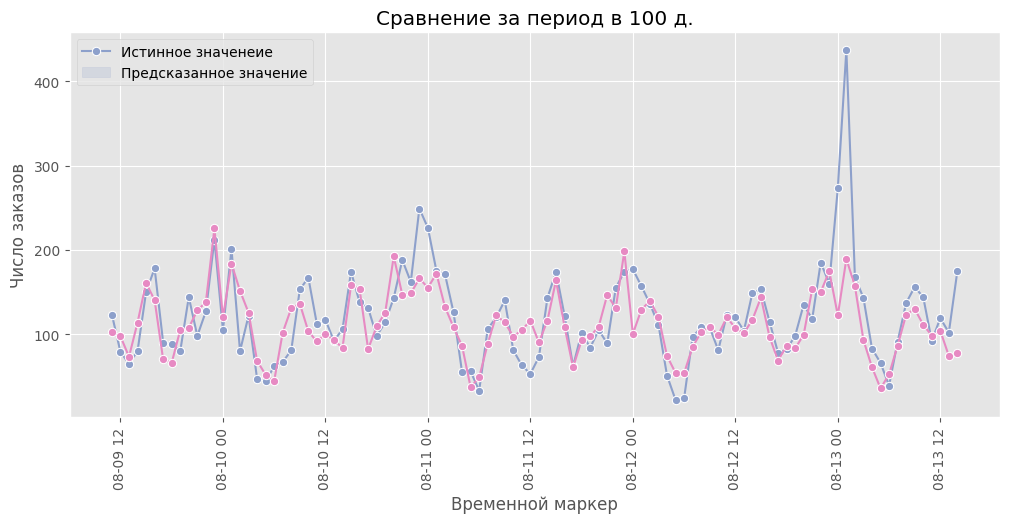

In [48]:
get_plot_ts(X_train_lr, y_train_lr, X_valid_lr, y_valid_lr, y_pred, full=False, period=100, need_exp=True)

На графике мы видим, что регрессия справилась не так уж и плохо, но не смогла предугадать резкий всплеск

### SARIMA <a class="anchor" id="model-sarima"></a>

Мы уже установили необходимые нам значения (приблизительно)

$(p,d,q)*(P,D,S){s} = (3,1,1)*(1,1,3)^{24}$

In [49]:
#используем тренировочную выборку
#перепробовав значения, остановился на самых оптимальных
model_sarima = SARIMAX(X_train_lr['num_orders'],
                       order=(3,1,1), seasonal_order=(1,1,3,24),
                      exog=X_train_lr['hour_sin'])

In [50]:
#делаем фит
model_fit = model_sarima.fit(method='lbfgs', cov_type='approx')

WARNING - (py.warnings._showwarnmsg) - c:\users\cripe\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




In [51]:
#предсказанные значения
y_hat = model_fit.predict(start=y_valid_lr.index[0], 
                          end=y_valid_lr.index[-1], 
                          exog=X_valid_lr['hour_sin'], 
                          dynamic=True)

In [52]:
get_rmse(y_valid_lr, y_hat, 'SARIMA')

'RMSE SARIMA: 41.278470001876336'

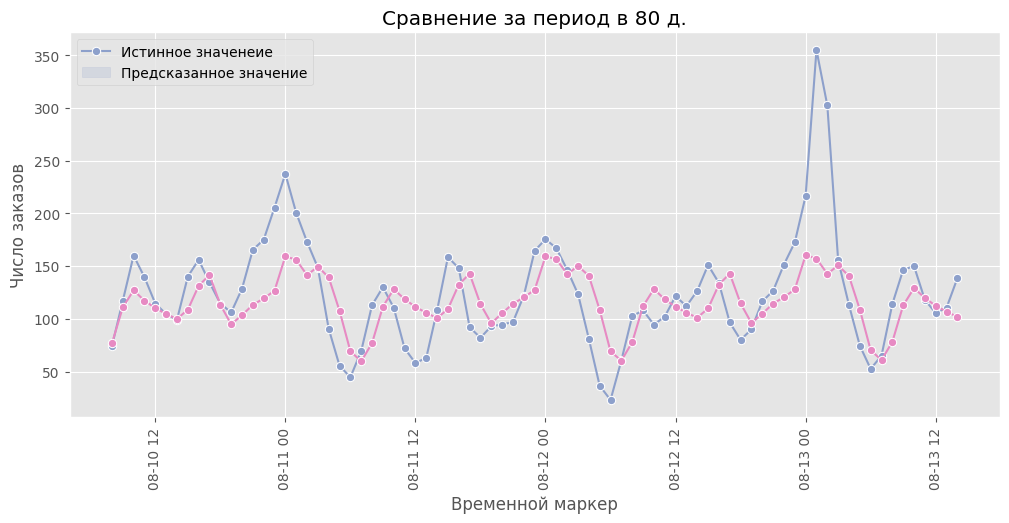

In [53]:
#построим график
get_plot_ts(X_train_lr, y_train_lr, 
            X_valid_lr, y_valid_lr, 
            y_hat, roll=2, full=False, 
            period=80)

In [54]:
#посмотрим на ошибки
pd.DataFrame(data={'valid':y_valid_lr.values, 
          'pred' : y_hat.values})

valid        pred
0    215.0  147.312741
1     91.0  132.462724
2     44.0   78.774071
3     39.0   51.421691
4     73.0   54.021990
..     ...         ...
391  144.0  126.219139
392   92.0  113.274733
393  119.0  111.441339
394  102.0  102.127009
395  175.0  101.498523

[396 rows x 2 columns]

Sarimax уловил движение линии

### LSTM neural-network <a class="anchor" id="model-lstm"></a>

Напишем класс, который создаст необходимый для обучения нейронной сети датасет

In [55]:
class nn_datasets:
    """
    :::data - pandas датафрейм
    :::window - скользящее окно, сколько предыдущих наблюдений будет использовано
    :::horizon - сколько значений нужно предсказать
    :::train_len - сколько наблюдений будет в трейне
    :::test_len - сколько наблюдений будет в тесте
    """
    
    def __init__(self, data, window, horizon, train_len, test_len, val_size=0.1):
        
        self.window = window
        self.horizon = horizon
        #скалер, использующий значения только из трейна
        self.sc = MinMaxScaler().fit(data.iloc[:train_len])
        self.data = self.sc.transform(data).reshape(1,-1)[0]
        self.train_len = train_len
        self.test_len = test_len
        self.val_size = val_size
    
    def create_xy(self):
        
        #функция собирает наблюдения X размером window
        #для предсказания Y размером horizon
        X, y = [], []
        
        for i in range(len(self.data)-self.window-self.horizon):
            X.append(self.data[i : i+self.window])
            y.append(self.data[(i+self.window) : (i+self.window+self.horizon)])
        
        return X, y
    
    def reverse_transform(self, x):
        
        #обратное преобразование скалера
        return self.sc.inverse_transform(x)
    
    def to_tensor(self, x):
        
        #переводит array в tensor
        return torch.tensor(data=x, dtype=torch.float32).unsqueeze(1)
    
    def get_datasets(self):
        
        #получаем датасет
        X, y = self.create_xy()
        #разбиваем на подвыборки
        X_train, y_train = X[:-self.test_len], y[:-self.test_len]
        X_test, y_test = X[-self.test_len:], y[-self.test_len:]
        
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=self.val_size, shuffle=False)
        
        #конвертим в тензоры
        X_train = self.to_tensor(X_train)
        X_valid = self.to_tensor(X_valid)
        X_test = self.to_tensor(X_test)
        y_train = self.to_tensor(y_train)
        y_valid = self.to_tensor(y_valid)
        y_test = self.to_tensor(y_test)
        
        return X_train, X_valid, X_test, y_train, y_valid, y_test
            

Теперь создадим класс нейронной сети

In [56]:
class LSTM(nn.Module):
    
    """
    :::input_size - количество признаков(features)
    :::hidden_size - гиперпараметр
    :::output_size - сколько значений предсказываем
    :::dropout - вероятность дропаута, по умолчанию - 0
    """
    
    def __init__(self, input_size, hidden_size, output_size, dropout=.0):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        #инициализируем lstm-архитектуру
        #и два линейных слоя
        self.lstm = nn.LSTM(input_size=self.input_size,
                           hidden_size=self.hidden_size)
        self.linear1 = nn.Linear(self.hidden_size, 128)
        self.linear2 = nn.Linear(128, self.output_size)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x, h=None):
        
        #начинаем с холодного старта - hidden и cell состояние отсутствутют
        out, h = self.lstm(x, h)
        last_hidden = out[:, -1]
        out = self.linear1(last_hidden)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear2(out)
        
        return out, h

In [57]:
#функция для предсказания
def get_prediction_nn(model, warm_set, x_test, y_test):
    
    """
    :::warm_set - датасет для инициализации состояний cell и hidden,
    :::лучше использовать предыдущий набор для предсказания,
    :::например, train->valid или valid->test
    """
    
    model.eval()
    _, h_list = model(warm_set)
    #забираем последние состояния
    h = tuple([(h[-1,-1,:]).unsqueeze(-2).unsqueeze(-2) for h in h_list])
    
    predicted = []
    for_loss = []
    for batch in x_test.tolist():
        batch = torch.tensor(data=[batch])
        y, h = model(batch, h)
        predicted.append(y.tolist())    
    print(f'MSE loss for not-scaled test: {criterion(torch.tensor(predicted), y_test).item()}')
    
    #собираем предсказанные значения, первое и второе предсказанное значение
    first_value = [value[0][0] for value in predicted]
    second_value = [value[0][-1] for value in predicted]
    first_value_test = [value[0][0].item() for value in y_test]
    second_value_test = [value[0][-1].item() for value in y_test]  
    
    #делаем обратную трансформацию
    first_value = prepare.reverse_transform(pd.DataFrame(first_value))
    second_value = prepare.reverse_transform(pd.DataFrame(second_value))
    first_value_test = prepare.reverse_transform(pd.DataFrame(first_value_test))
    second_value_test = prepare.reverse_transform(pd.DataFrame(second_value_test))

    return first_value, second_value, first_value_test, second_value_test

In [58]:
#сколько признаков мы используем для предсказания
n_features = 24
#сколько значений хотим предсказать
n_out = 2
#размеры возьмем уже созданных датасетов
train_len, test_len = len(data_train), len(data_test)
prepare = nn_datasets(data, window=n_features,
                     horizon=n_out, train_len=train_len,
                     test_len=test_len)

X_train_nn, X_valid_nn, X_test_nn, y_train_nn, y_valid_nn, y_test_nn = prepare.get_datasets()

WARNING - (py.warnings._showwarnmsg) - C:\Users\cripe\AppData\Local\Temp\ipykernel_1040\864968507.py:41: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)




In [59]:
#Длина секвенции x Размер батча x Число признаков
print(f'Размер трейна X - {X_train_nn.size()}, target - {y_train_nn.size()}')
print(f'Размер валидации X - {X_valid_nn.size()}, target - {y_valid_nn.size()}')
print(f'Размер теста X - {X_test_nn.size()}, target - {y_test_nn.size()}')

Размер трейна X - torch.Size([3555, 1, 24]), target - torch.Size([3555, 1, 2])
Размер валидации X - torch.Size([395, 1, 24]), target - torch.Size([395, 1, 2])
Размер теста X - torch.Size([440, 1, 24]), target - torch.Size([440, 1, 2])


In [60]:
#инициализируем нейросеть, оптимизатор и функцию потерь
lr = .005
hidden_size = 64
net = LSTM(input_size=n_features, output_size=n_out, hidden_size=hidden_size, dropout=0.3)
optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)
criterion = nn.MSELoss()

In [61]:
#запускаем тренировку 
#мы будем записывать значение ошибки, записывая как лучшую модель модель
#с наименьшей ошибкой.
epochs = 120
training, validation = [], []
best_model = None
min_val_treshold = np.inf

for epoch in range(epochs):
    net.train()
    prediction, _ = net(X_train_nn)
    loss = criterion(prediction.unsqueeze(1), y_train_nn)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        net.eval()
        val_pred, _ = net(X_valid_nn)
        val_loss = criterion(val_pred.unsqueeze(1), y_valid_nn)
    
        if val_loss.item() < min_val_treshold:
            min_val_treshold = val_loss.item()
            best_model = copy.deepcopy(net)

    
    training.append(loss.item())
    validation.append(val_loss.item())
    
    
    if epoch % 20 == 0:
        print(f'Epoch {epoch + 1}/{epochs}')
        print(f'train loss - {np.round(loss.item(), 4)}')
        print(f'val loss - {np.round(val_loss.item(), 4)}')
        print('-' * 20)
        print()

Epoch 1/120
train loss - 0.0921
val loss - 0.1159
--------------------

Epoch 21/120
train loss - 0.0195
val loss - 0.0491
--------------------

Epoch 41/120
train loss - 0.0142
val loss - 0.0254
--------------------

Epoch 61/120
train loss - 0.0112
val loss - 0.02
--------------------

Epoch 81/120
train loss - 0.0103
val loss - 0.0197
--------------------

Epoch 101/120
train loss - 0.01
val loss - 0.0187
--------------------



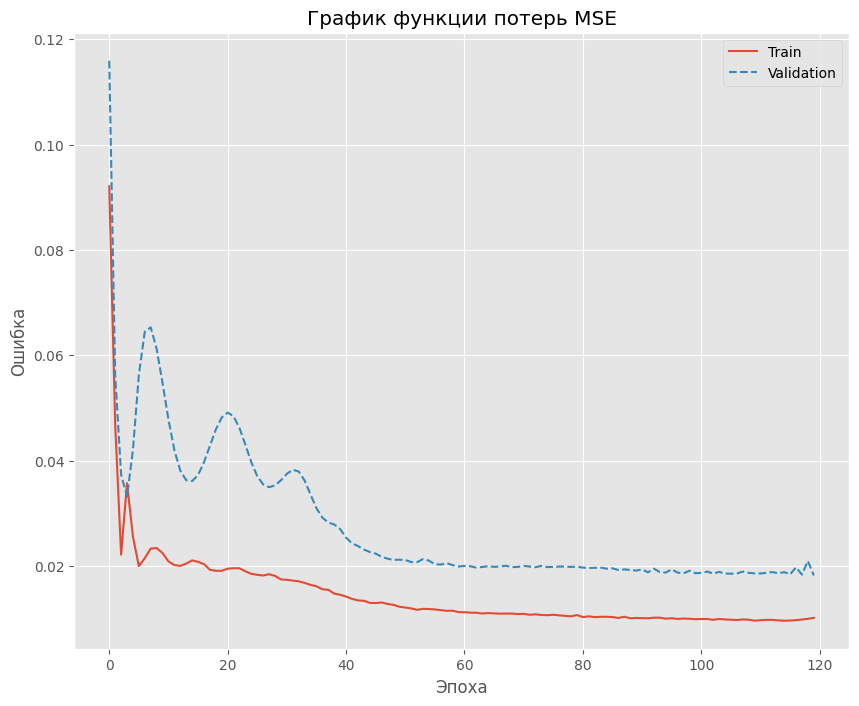

In [62]:
plt.plot(training)
plt.plot(validation, '--')
plt.title('График функции потерь MSE')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend(labels=['Train', 'Validation'])

In [63]:
#получаем отмасштабированные значения для графиков и проверки
y_pred_nn_0, y_pred_nn_1, y_true_nn_0, y_true_nn_1 = \
    get_prediction_nn(best_model, X_train_nn, X_valid_nn, y_valid_nn)

MSE loss for not-scaled test: 0.018054170534014702


In [64]:
nn_rmse_0 = np.sqrt(mean_squared_error(y_pred_nn_0, y_true_nn_0))
nn_rmse_1 = np.sqrt(mean_squared_error(y_pred_nn_1, y_true_nn_1))            
print(f'Средняя ошибка для предсказанных чисел: {(nn_rmse_0 + nn_rmse_1)/2}')

Средняя ошибка для предсказанных чисел: 33.98703873486615


In [65]:
#добавим ошибку в словарь, т.к. мы посчитали ее вне функции
total_dict['Pytorch'] = (nn_rmse_0 + nn_rmse_1)/2

In [66]:
#графики для нейронной сети
def nn_plot(pred, true, start=0, finish=-1, title='LSTM'):
    
    plt.plot(true[start:finish], 
            color=color[0], marker='o', alpha=0.4)

    plt.plot(pred[start:finish],
             color=color[1], 
             alpha=0.5, marker='x', label='XX')

    plt.title(title)
    plt.xlabel('Распределение по дням')
    plt.ylabel('Количество заказов')
    plt.legend(labels=['Истинное значение', 'Предсказанное значение'])
    plt.show()

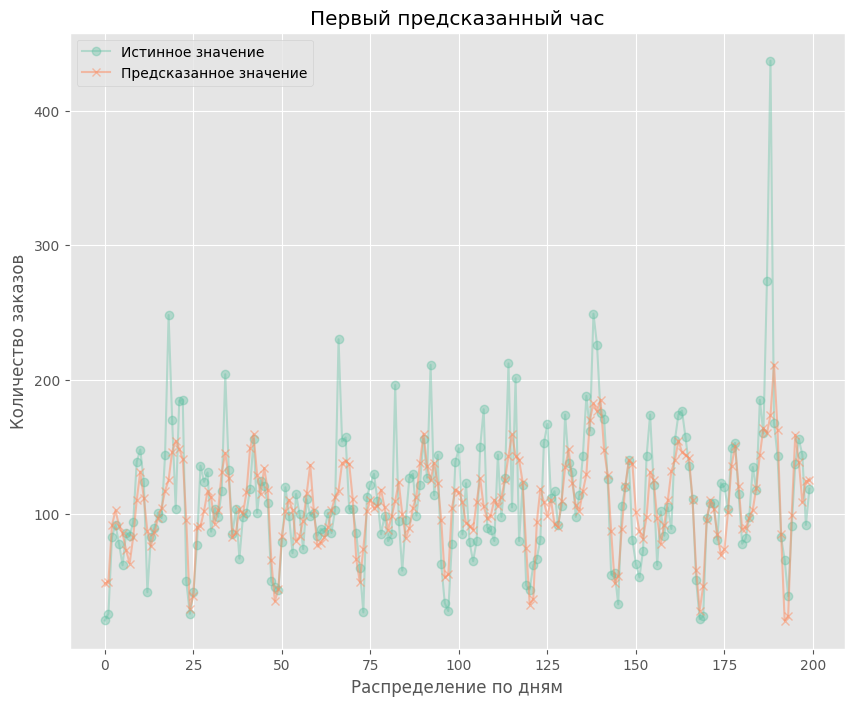

In [67]:
#первое предсказзаное значение
nn_plot(y_pred_nn_0, 
        y_true_nn_0, 
        title='Первый предсказанный час',
        start=-200,
        finish=None)

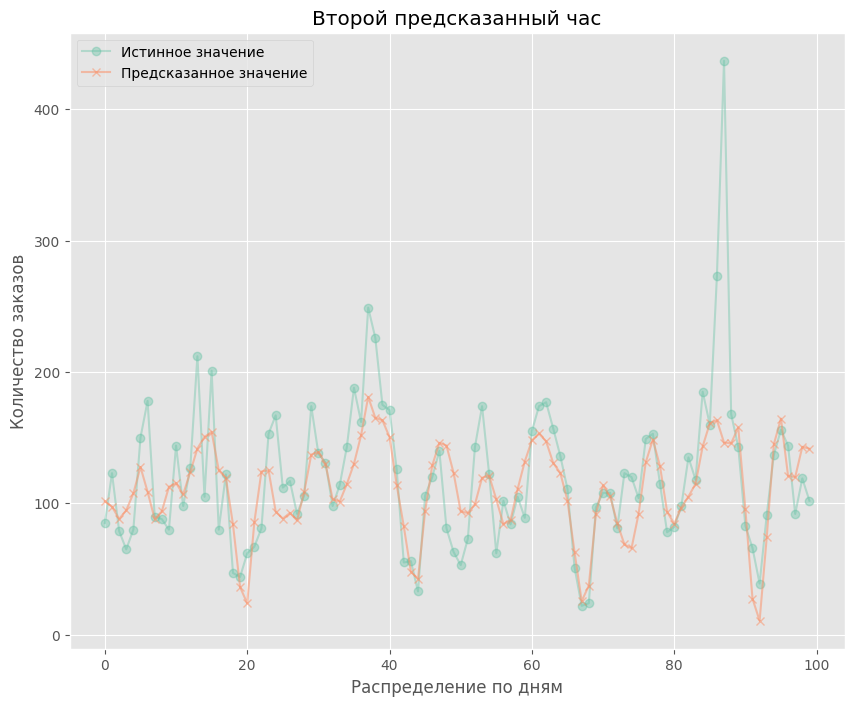

In [68]:
#Второе предсказанное значение
nn_plot(y_pred_nn_1, 
        y_true_nn_1, 
        title='Второй предсказанный час',
        start=-100,
        finish=None)

Оба графика хорошо описывают реальные данные, что говорит о неплохой точности предсказания не только на один шаг, но и на два шага вперед.

### NeuralProphet <a class="anchor" id="model-nprohet"></a>

Вместо использования Prophet от Facebook, мы используем его модифицированную версию - Neural

In [69]:
def for_facebook(data, target_name, need_log=False):
    
    fbook_data = pd.DataFrame(data={
        'y' : (data[target_name] if not need_log else np.log1p(data[target_name]))
    })
    fbook_data = fbook_data.reset_index()
    fbook_data.columns=['ds', 'y']
    
    return fbook_data

In [70]:
#готовим валидационный датасет
fbook_train = for_facebook(X_train_lr, 'num_orders', need_log=True)
fbook_valid = for_facebook(X_valid_lr, 'num_orders', need_log=True)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

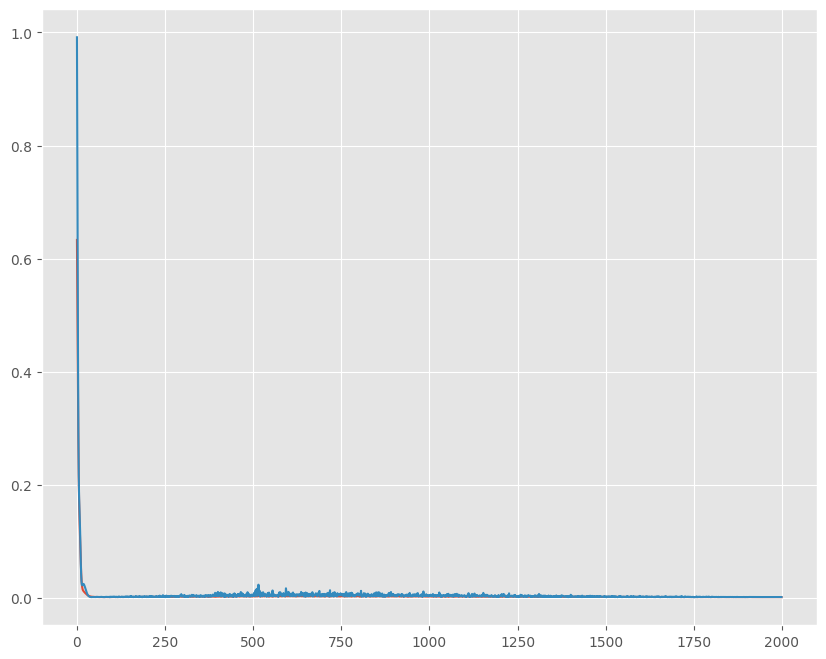

In [71]:
#запускаем и смотрим кросс-валидацию
nprophet = NeuralProphet(learning_rate=0.05, 
                         epochs=2000, 
                         num_hidden_layers=4, 
                         seasonality_mode='multiplicative')
metrics = nprophet.fit(fbook_train, freq='H', validation_df=fbook_valid, progress='plot')

In [72]:
#смотрим результат
metrics

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
0     7.326389  7.777157  0.991320          0.0      0  6.385653  6.841027   
1     6.410807  6.646581  0.801447          0.0      1  5.837115  6.130951   
2     5.490690  5.574577  0.613272          0.0      2  5.282676  5.447091   
3     4.570519  4.592586  0.430391          0.0      3  4.717068  4.796133   
4     3.702742  3.803427  0.295089          0.0      4  4.181238  4.226252   
...        ...       ...       ...          ...    ...       ...       ...   
1995  0.229450  0.305047  0.001900          0.0   1995  0.258538  0.341935   
1996  0.229453  0.305053  0.001900          0.0   1996  0.259759  0.345115   
1997  0.229452  0.305052  0.001900          0.0   1997  0.258199  0.342989   
1998  0.229455  0.305055  0.001900          0.0   1998  0.259902  0.343388   
1999  0.229455  0.305055  0.001900          0.0   1999  0.258124  0.342460   

          Loss  RegLoss  
0     0.633118      0.0  
1     0.540645      0.0  
2     0.449188      0.0  
3     0.357589      0.0  
4     0.277228      0.0  
...        ...      ...  
1995  0.001762      0.0  
1996  0.001771      0.0  
1997  0.001760      0.0  
1998  0.001769      0.0  
1999  0.001760      0.0  

[2000 rows x 9 columns]

In [73]:
#составим предсказание
fbook_train_check = fbook_train.copy()
future = nprophet.make_future_dataframe(fbook_train_check, periods=fbook_valid.shape[0])

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [74]:
np_y_hat = nprophet.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.747% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.747% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 112it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [75]:
get_rmse(np.exp(fbook_valid['y'])-1, np.exp(np_y_hat['yhat1'])-1, 'NeuralProphet')

'RMSE NeuralProphet: 32.358096273317926'

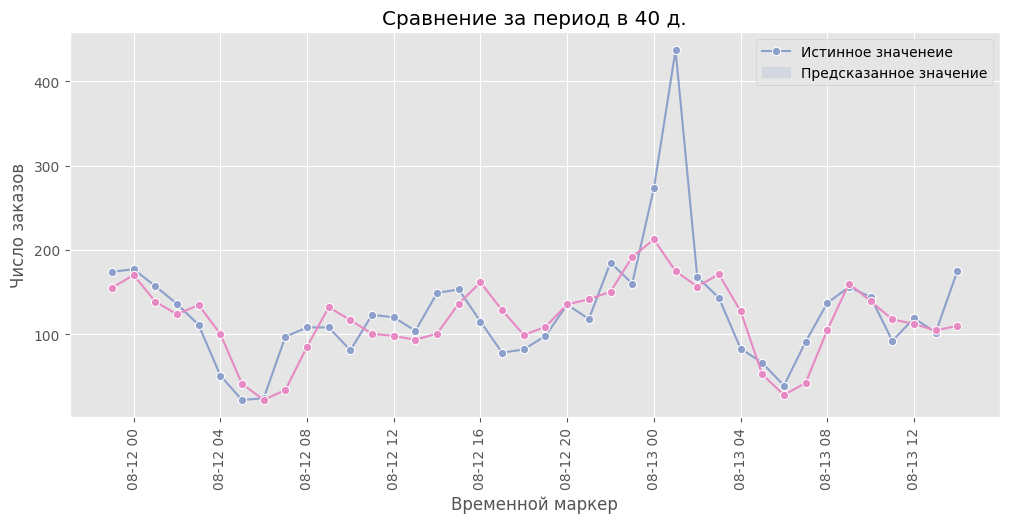

In [76]:
get_plot_ts(X_train_lr, y_train_lr, 
            X_valid_lr, y_valid_lr, 
            np_y_hat['yhat1'], 1, False, 40, need_exp=True)

И по метрике, и на графике - Neural Prophet - победитель на фоне остальных алгоритмов. Во всяком случае, по умолчанию, модель смотрит лишь на 1 интервал вперед (в нашем случае это час). Осталось проверить на тестовой выборке.

## Тестирование <a class="anchor" id="test"></a>

Мы нашли лучшую модель, но стоит посмотреть назад, какой путь мы прошли. Ниже приведены RMSE каждой модели, с которой наам посчастливилось поработать.

In [77]:
#приводим в пандосовский вид
result = pd.DataFrame(total_dict, index=[1]).T
result.columns=['Итоговый RMSE']

In [78]:
result

Итоговый RMSE
CatboostRegression      32.051232
SARIMA                  41.278470
Pytorch                 33.987039
NeuralProphet           32.358096

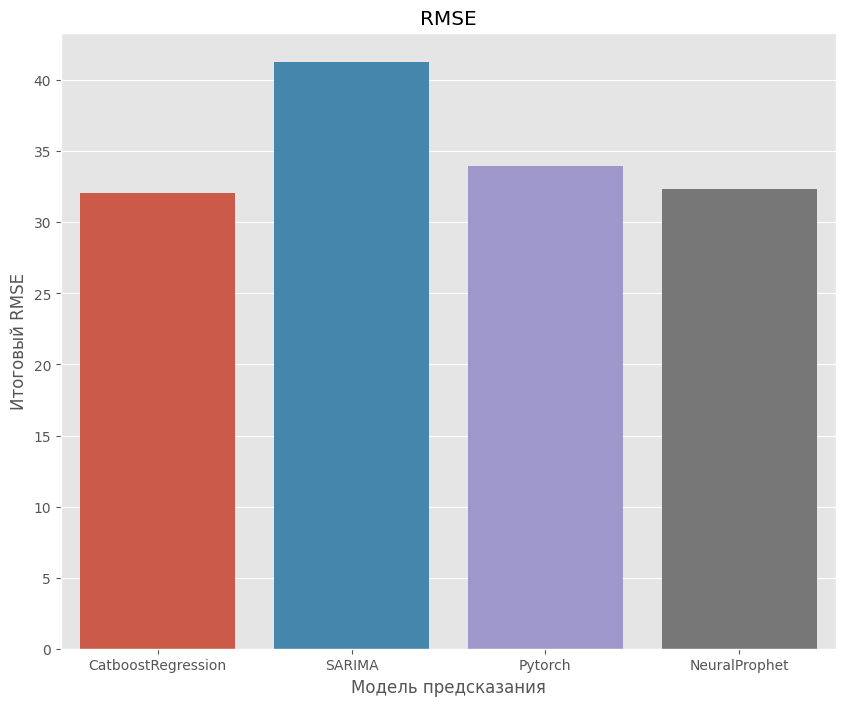

In [79]:
#строим график
sns.barplot(data=result, x=result.index, y='Итоговый RMSE')
plt.title('RMSE')
plt.xlabel('Модель предсказания')
plt.show()

In [80]:
#скорректируем наш тренировочный сет
y_test = data_test['num_orders']
data_test = data_test.reset_index()['datetime']
data_test.columns=['ds']

Так как мы не можем предсказывать далеко вперед, то выбрав лучшую модель, мы объединяем трейн и валидацию для повторного обучения

In [81]:
#объединяем
train_valid_date = pd.concat((fbook_train, fbook_valid), axis=0)

In [82]:
train_valid_date['y']  = np.log1p(train_valid_date['y'])

In [92]:
#снова обучаем нашу лучшую модель с теми же параметрами
nprophet = NeuralProphet(seasonality_mode='daily', 
                         yearly_seasonality=False,
                         daily_seasonality=True,
                         weekly_seasonality=True,
                         loss_func='MSE',
                         n_forecasts=2,
                         learning_rate=0.1)
metrics = nprophet.fit(train_valid_date, freq='H')
future_final = nprophet.make_future_dataframe(train_valid_date, periods=data_test.shape[0])
final = nprophet.predict(future_final)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.975% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 131
ERROR - (NP.time_net.__init__) - Seasonality Mode daily not implemented. Defaulting to 'additive'.


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.975% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.773% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.773% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 124it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [93]:
#на выходе
final

ds     y     yhat1     trend  season_weekly  season_daily
0   2018-08-13 15:00:00  None  1.784337  1.732953       0.009172      0.042212
1   2018-08-13 16:00:00  None  1.813990  1.732993       0.006733      0.074263
2   2018-08-13 17:00:00  None  1.769389  1.733034       0.004187      0.032169
3   2018-08-13 18:00:00  None  1.715292  1.733074       0.001563     -0.019345
4   2018-08-13 19:00:00  None  1.727351  1.733114      -0.001110     -0.004654
..                  ...   ...       ...       ...            ...           ...
435 2018-08-31 18:00:00  None  1.761501  1.750519       0.030326     -0.019345
436 2018-08-31 19:00:00  None  1.776557  1.750560       0.030652     -0.004654
437 2018-08-31 20:00:00  None  1.815760  1.750600       0.030695      0.034465
438 2018-08-31 21:00:00  None  1.818763  1.750641       0.030453      0.037670
439 2018-08-31 22:00:00  None  1.822800  1.750681       0.029927      0.042192

[440 rows x 6 columns]

In [101]:
final_y = np.exp(np.exp(final['yhat1'])-1)-1

In [102]:
#итоговой RMSE
get_rmse(y_test, final_y)

'RMSE Empty: 43.893699105971514'

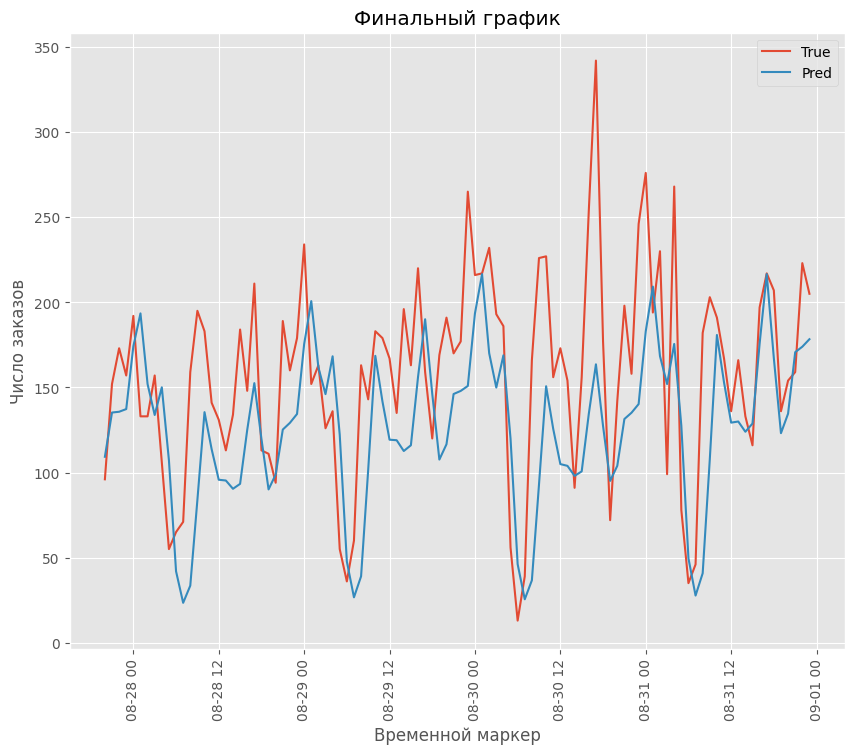

In [111]:
#строим финальный график по всему набору данных
sns.lineplot(x=data[-100:].index, y=data['num_orders'][-100:], label='True')
sns.lineplot(x=data[-100:].index, y=final_y[-100:], label='Pred')
plt.title('Финальный график')
plt.xlabel('Временной маркер')
plt.ylabel('Число заказов')
plt.xticks(rotation=90)
plt.show()

## Заключение <a class="anchor" id="result"></a>

В данном проекте мы практически поработали с временными рядами, начав с простых проверок на монотонность данных, то есть поочередности данных, без пробелов, сделали ресэмплинг - метод лучшего и более комплексного отражения данных. Мы изучили такие важные понятие временных рядов как тренд и сезонность (было бы данных побольше, можно было бы и цикличность зацепить). Попытались сделать модель на основе SARIMA - старого способа предсказания, созданного эконометристами для возможности предсказания, сделали модель на основе бустинга, который неплохо справился с задачей, т.к. регрессия - не лучший способ работы с временными рядами, если только они не избавлены от тренда, цикличности, сильного шума и прочего, что есть практически всегда.

Итоговое предсказание по RMSE на тестовой выборке составило менее 48 такси, что неплохо, если брать во внимание дамми-предсказание в целые 80 машин. Таким мы можем и сэкономить, и подстраховаться.